# Multiclass classification from CSV file

### Basic Modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle

In [2]:
from lumin.plotting.data_viewing import plot_feat
from sklearn.model_selection import train_test_split
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
import torch.nn as nn

In [3]:
from pathlib import Path
PATH = Path('../../data')

In [4]:
!ls {PATH}

feats.pkl
gspy-db-20180813_O1_filtered_t1126400691-1205493119_snr7.5_tr_gspy.csv
hdf5
input_pipe.pkl
readme.txt
test.hdf5
train.hdf5
val.hdf5


## Data preparation

### Data import from CSV file 
Read file into a pandas dataframe.

In [11]:
data = pd.read_csv(PATH/'gspy-db-20180813_O1_filtered_t1126400691-1205493119_snr7.5_tr_gspy.csv')

In [12]:
data.head()

,GPStime,peakFreq,snr,centralFreq,duration,bandwidth,id,ifo,label
0,1.134828e+09,32.246,40.137,1601.119,7.250,3183.373047,LYD73IJEbP,H1,Scattered_Light
1,1.134164e+09,29.897,38.256,2965.068,2.500,5894.235352,kQOi8X6807,H1,Scattered_Light
2,1.134478e+09,29.636,32.589,41.479,2.313,47.056068,wypbhS6TAa,H1,Scattered_Light
3,1.134478e+09,31.943,29.462,2532.243,3.000,5035.515137,aKFWKfLE8l,H1,Scattered_Light
4,1.137056e+09,32.552,28.537,1167.148,4.750,2324.383057,yWSM6mnbBM,H1,Scattered_Light


In [13]:
#data.drop(columns=['GPStime'], inplace=True)
data['ifo'] = data['ifo'].map({l:i for i,l in enumerate(set(data.ifo))})
data['label'] = data['label'].map({l:i for i,l in enumerate(sorted(set(data.label)))})
data.rename(index=str, columns={'label':'gen_target'}, inplace=True)

In [17]:
df, test = train_test_split(data, test_size=0.33, random_state=7)

### Preprocessing

In [18]:
print([f for f in df.columns])

['GPStime', 'peakFreq', 'snr', 'centralFreq', 'duration', 'bandwidth', 'id', 'ifo', 'gen_target']


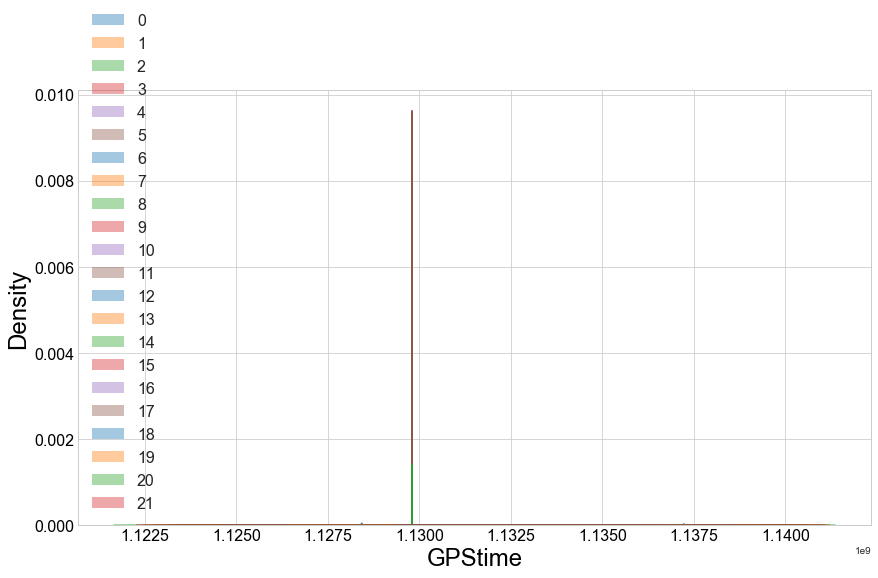

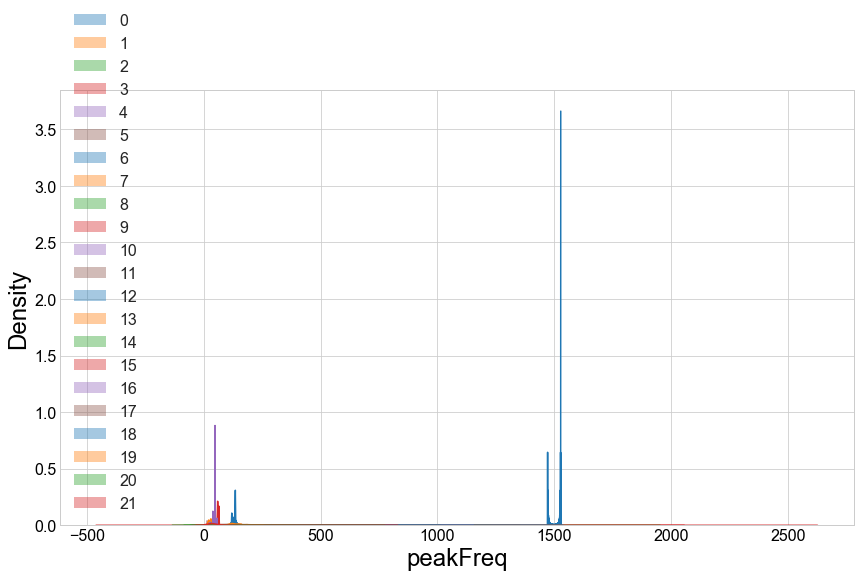

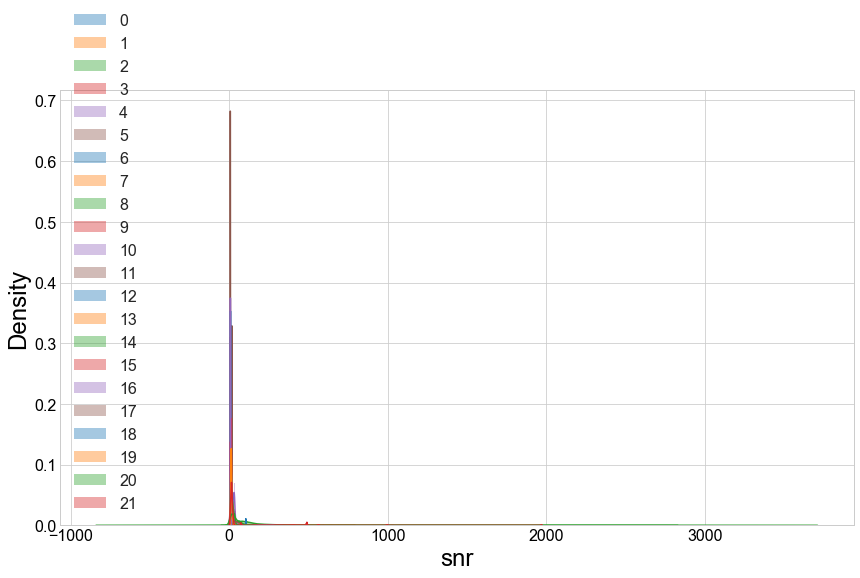

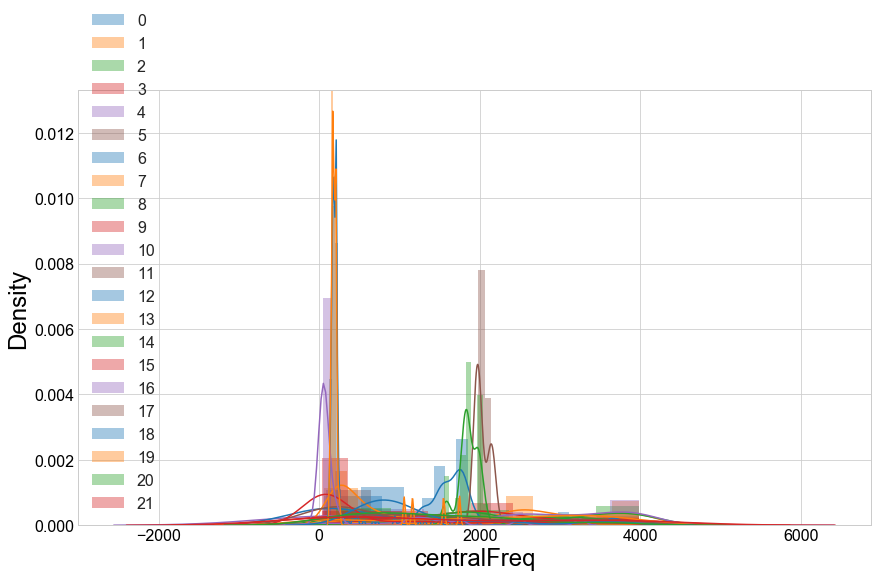

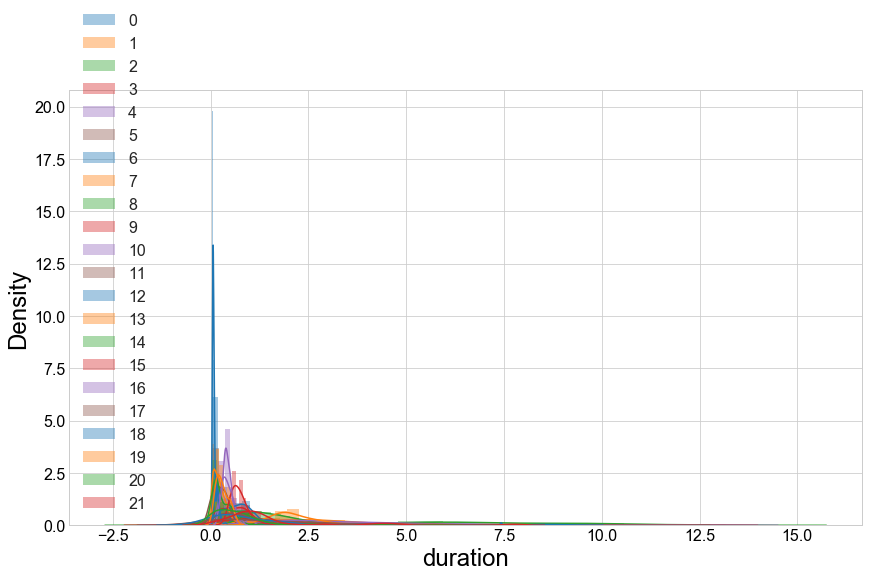

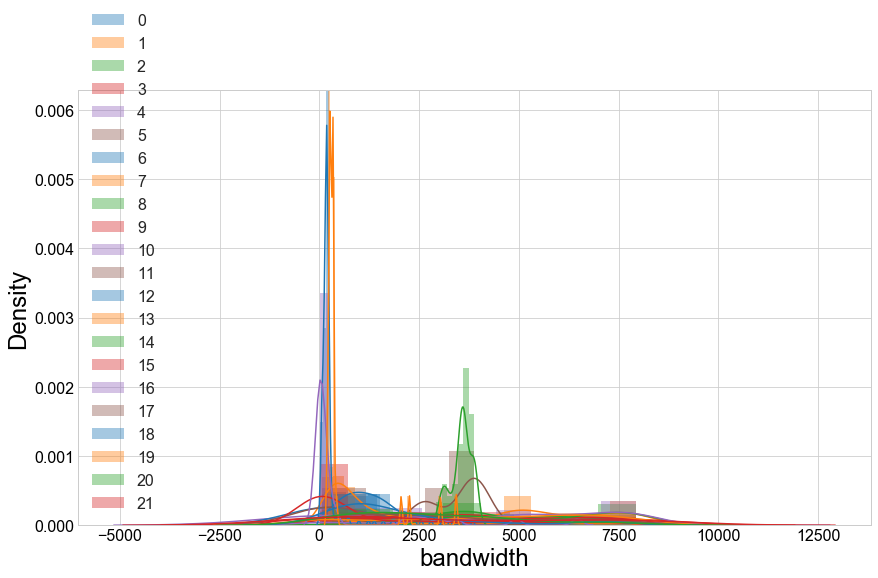

In [19]:
for f in df.columns:
    if f not in ['gen_target', 'ifo', 'id']:
        plot_feat(df, f, cuts=[(df.gen_target==t) for t in set(df.gen_target)],
                  labels=[str(t) for t in set(df.gen_target)], show_moments=False)  

For quick access, we'll define here all the sets of features we'll later want use.

In [20]:
gen_feats = [f for f in df.columns if 'gen_' in f]
misc_feats = ['id']
wgt_feat = 'gen_weight'
cat_feats = ['ifo']
cont_feats = [f for f in df.columns if f not in gen_feats+cat_feats+misc_feats]
print(len(cat_feats), cat_feats)
print(len(cont_feats), cont_feats)
train_feats = cont_feats + cat_feats

1 ['ifo']
6 ['GPStime', 'peakFreq', 'snr', 'centralFreq', 'duration', 'bandwidth']


To create our validation set, we'll eventually pull out a random sample, however it can be useful to ensure as much similarity as possible by doing a stratified split using the categories and classes in the data. `ids2unique` maps each set of categories to a unique integer, allowing us to create a single set of values to use as the stratification key.

In [21]:
from lumin.utils.misc import ids2unique
df['gen_strat_key'] = ids2unique(df[cat_feats].values)

In [22]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [23]:
df.columns[df.isna().any()].tolist()

[]

#### Train-validation split 

In [24]:
val_sz = 0.2
train_df, val_df = train_test_split(df, test_size=val_sz, stratify=df.gen_strat_key, random_state=1111)

Having pulled out a stratified random subsample, we can check whether it really is representative of the train data (and our test set if we had one) by seeing whether we can use the input features to identify which dataset each event belongs to. If there our some features which allow the sets to be identified, then we could remove them from the inputs to improve the generalisation of the model.

`check_val_set` runs some random forests to try and predict the originating datasets of the events, and then returns the area under the ROC curve for the classifiers. Ideally this should be 0.5, indicating it can only do as well as random guessing. Training and inference use weights to account for the fact that the datasets may have uneven populations.

In [25]:
from lumin.utils.data import check_val_set
check_val_set(train_df[train_feats], val_df[train_feats], test[train_feats])


AUC for train-validation discrimination = 0.5016720758844478
Top 10 most important features are:
   index      Feature  Importance
0      0    bandwidth    0.010749
1      1      GPStime    0.004516
2      2     peakFreq   -0.000596
3      3          ifo   -0.008772
4      4  centralFreq   -0.009613
5      5     duration   -0.019781
6      6          snr   -0.020069

AUC for test-validation discrimination = 0.4882156163615208
Top 10 most important features are:
   index      Feature  Importance
0      0          ifo    0.000902
1      1     peakFreq    0.000069
2      2      GPStime   -0.004093
3      3  centralFreq   -0.007183
4      4    bandwidth   -0.013739
5      5     duration   -0.020814
6      6          snr   -0.031885


#### Final preprocessing
The network weights will use initialisation schemes which expect the inputs to be unit Gaussian. We'll use sklearn pipelines to package transformations which alter the data to have mean zero and standard deviation one.

In [26]:
from lumin.data_processing.pre_proc import fit_input_pipe
input_pipe = fit_input_pipe(train_df, cont_feats, PATH/'input_pipe')

In [27]:
train_df[cont_feats] = input_pipe.transform(train_df[cont_feats])
val_df[cont_feats] = input_pipe.transform(val_df[cont_feats])
test[cont_feats] = input_pipe.transform(test[cont_feats])

Since we'll be using entity embeddings for the categorical features, we want to transform their codes to start from zero and increase incrementaly. We also need to make sure the validation (and test) sets receive the same transformaitions as the training set.

`proc_cats` does this and returns dictionaries of the both the mapping that was applied, and the cardinality of each feature.

In [28]:
from lumin.data_processing.pre_proc import proc_cats
cat_maps, cat_szs = proc_cats(train_df, cat_feats, val_df, test)
cat_maps, cat_szs

(OrderedDict([('ifo', {0: 0, 1: 1})]), OrderedDict([('ifo', 2)]))

### Weight processing

In [29]:
train_df['gen_weight'] = 1
for s in set(train_df.gen_target):
    train_df.loc[train_df.gen_target == s, 'gen_weight'] /= np.sum(train_df.loc[train_df.gen_target == s, 'gen_weight'])
train_df.gen_weight.sum()

22.0

### Conversion to fold file 

Having finished processing the data, we can now save it to h5py files in a format that `FoldYielder` will expect.

In [30]:
targ_feat = 'gen_target'

In [31]:
from lumin.data_processing.file_proc import df2foldfile
df2foldfile(df=train_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats=targ_feat,
            wgt_feat=wgt_feat, misc_feats=misc_feats,
            savename=PATH/'train', targ_type='float32', strat_key='gen_strat_key')

Saving fold 0 with 358 events
Saving fold 1 with 358 events
Saving fold 2 with 358 events
Saving fold 3 with 358 events
Saving fold 4 with 357 events
Saving fold 5 with 357 events
Saving fold 6 with 357 events
Saving fold 7 with 357 events
Saving fold 8 with 356 events
Saving fold 9 with 356 events


In [32]:
df2foldfile(df=val_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats=targ_feat,
            misc_feats=misc_feats,
            savename=PATH/'val', targ_type='float32', strat_key='gen_strat_key')

Saving fold 0 with 91 events
Saving fold 1 with 91 events
Saving fold 2 with 89 events
Saving fold 3 with 89 events
Saving fold 4 with 89 events
Saving fold 5 with 89 events
Saving fold 6 with 89 events
Saving fold 7 with 89 events
Saving fold 8 with 89 events
Saving fold 9 with 89 events


In [33]:
df2foldfile(df=test, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats='gen_target',
            misc_feats=misc_feats,
            savename=PATH/'test', targ_type='float32')

Saving fold 0 with 221 events
Saving fold 1 with 220 events
Saving fold 2 with 220 events
Saving fold 3 with 220 events
Saving fold 4 with 220 events
Saving fold 5 with 220 events
Saving fold 6 with 220 events
Saving fold 7 with 220 events
Saving fold 8 with 220 events
Saving fold 9 with 220 events


## Feature selection

Currently we're using all of the available information from the CSV file, however it contains an awful lot of high-level features which may not be useful for the regression. We can run a few checks to try and filter out the uneeded features.

`FoldYielder` is the base class we'll use to pull data from the h5py file. We can also recover the original dataframe via `get_df`, and deporcess it my adding the input pipe.

In [34]:
from lumin.nn.data.fold_yielder import FoldYielder
train_fy = FoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.add_input_pipe(input_pipe)
train_df = train_fy.get_df(inc_inputs=True, deprocess=True); train_df.head()

3572 candidates loaded


,GPStime,peakFreq,snr,centralFreq,duration,bandwidth,ifo,gen_target,gen_weight
0,1.134398e+09,137.710999,13.785004,241.077942,0.188,413.835022,0.0,7.0,0.001048
1,1.127404e+09,225.348999,27.710007,813.122986,0.219,1547.647705,0.0,7.0,0.001048
2,1.136263e+09,616.085999,9.473999,1468.729980,0.141,1939.360596,1.0,3.0,0.013333
3,1.128219e+09,339.876007,207.212006,1322.491943,1.888,2580.983154,0.0,8.0,0.004202
4,1.135869e+09,111.127998,26.050003,2954.473877,0.375,5840.626465,0.0,7.0,0.001048


A first step can be to check for duplication of information via similar features. `plot_dendrogram` uses Spearman's rank correlation and hierarchical clustering to group features by similarity. From right to left, features which are combined closer to the left are more similar, and it is worth checking whether one of a pair of features which are combined straight away can be safely removed (**N.B.** one of the features of a close clustering has to remain to otherwise the information of the pair is lost).

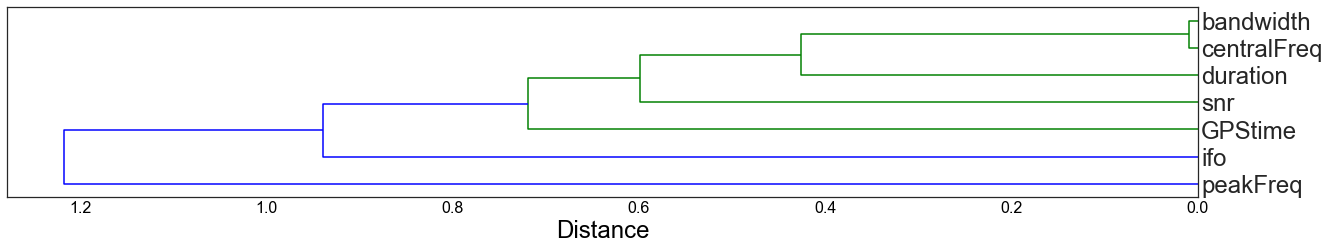

In [35]:
from lumin.plotting.data_viewing import plot_dendrogram
plot_dendrogram(train_df[train_feats])

In [36]:
df_trn, df_val = train_test_split(train_df, test_size=0.8)

We're mainly interested in filtering down the high-level features, and will assume that the random forests we'll be using will not be able to make as much use of the lower level information as the neural networks will, so we'll only test the high level features and add regularisation as necessary later.

Let's see which of the high-level features the RFs find useful. `rf_rank_features` wraps rfpimp and initially trains a RF using the data and eveluates it on the validation set. It then sequentially makes a copy of the data and randomises the order of one of the fetaures and then reevaluates the model performance, and compares it to the original score. If their is a large decrease in the score, then the feature which was randomised was very important in the model. If there is only a small decrease (or increase) in the score, then the feature was not important.

Having established the importance of the features, `rf_rank_features` then runs another training only using the features with importances higher the the `cut` argument. If there is no decrease in the score, the ignored features can probably be safely removed.

Optimising RF


Top ten most important features:
        Feature  Importance
0     peakFreq    0.319104
1     duration    0.305458
2          snr    0.250875
3      GPStime    0.076627
4          ifo    0.047936
5    bandwidth    0.001749
6  centralFreq   -0.000700


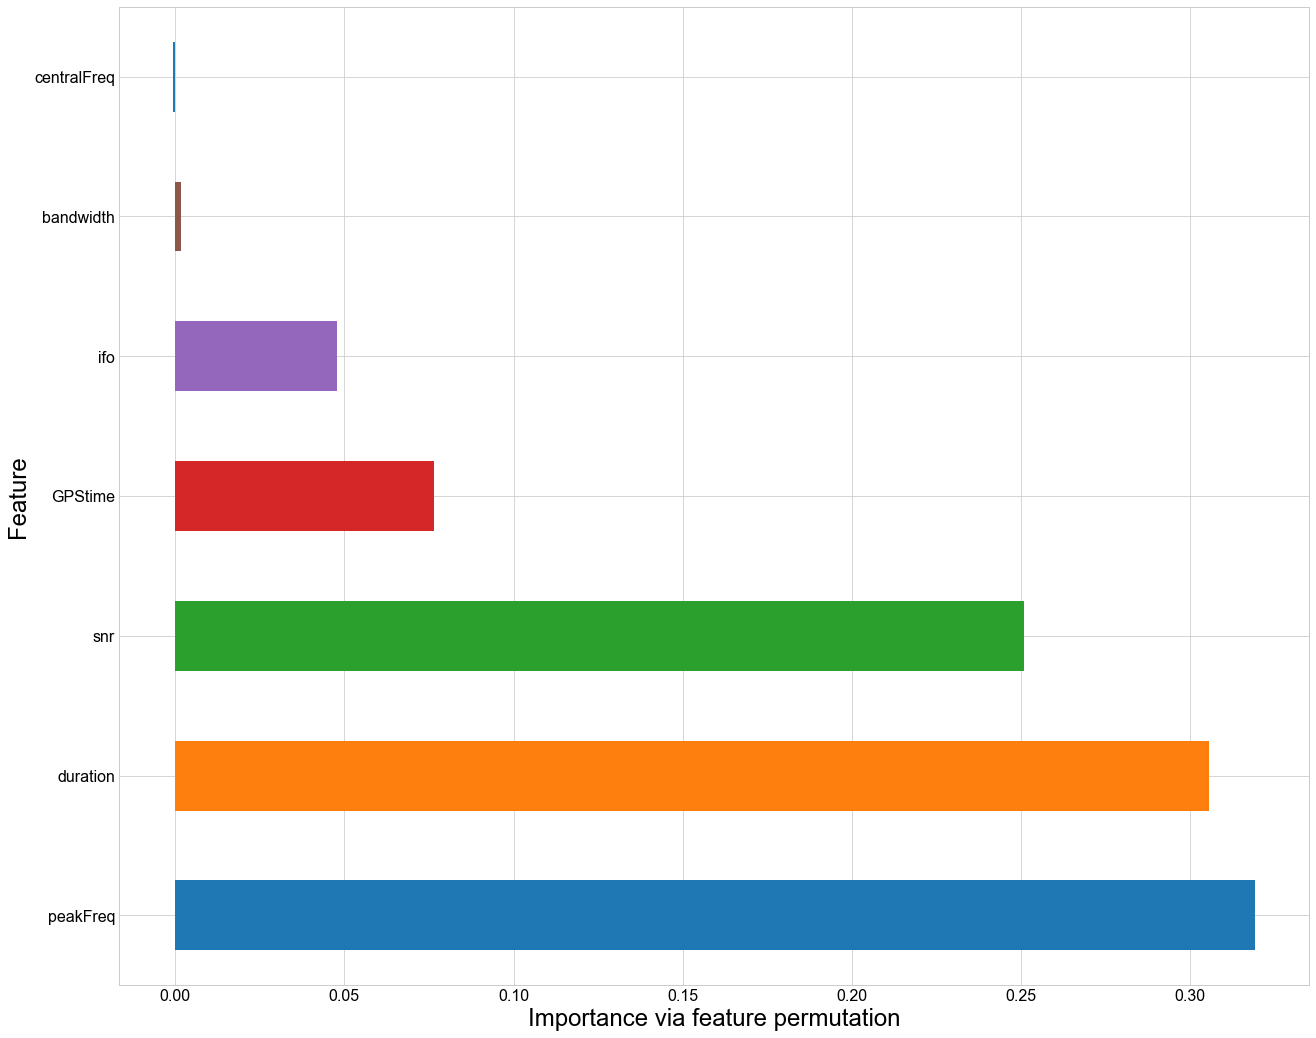


6 features found with importance greater than 0.001:
 ['peakFreq', 'duration', 'snr', 'GPStime', 'ifo', 'bandwidth']

Optimising new RF


Comparing RF scores, higher = better
All features:	0.82575
Top features:	0.82820


In [37]:
from lumin.optimisation.features import rf_rank_features
import_feats = rf_rank_features(df_trn, df_val, objective='classification', train_feats=train_feats, importance_cut=0.001)

In [38]:
from rfpimp import plot_corr_heatmap, feature_dependence_matrix, plot_dependence_heatmap

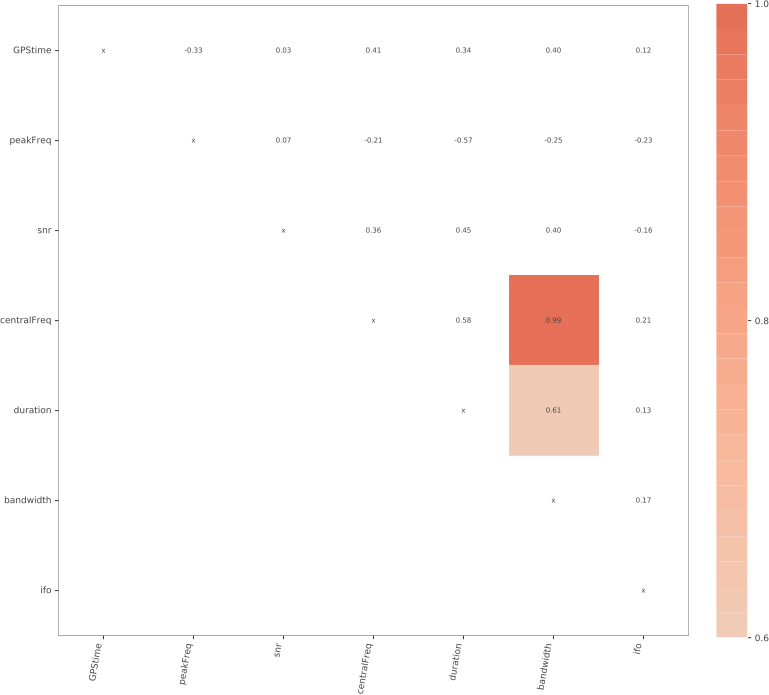

In [39]:
plot_corr_heatmap(df_trn[train_feats], figsize=(11,11), label_fontsize=9, value_fontsize=7)

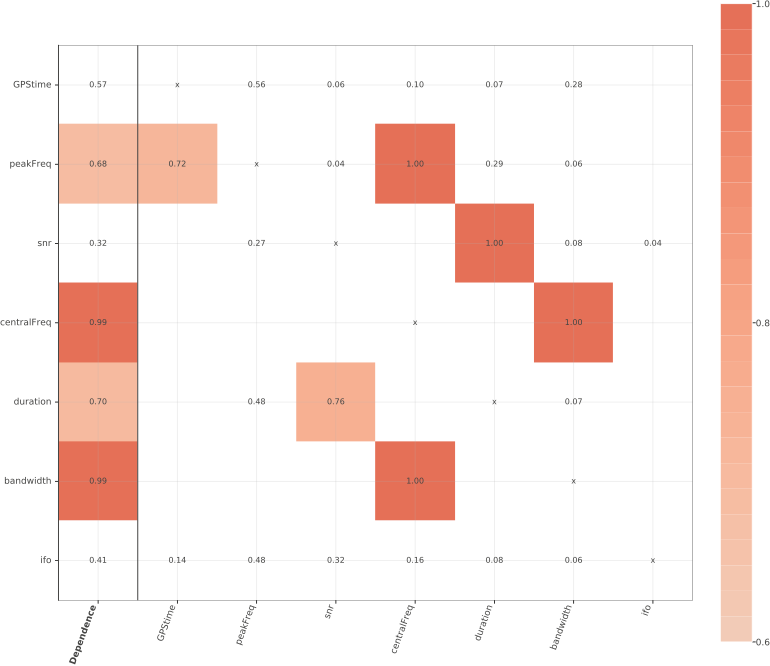

In [40]:
from sklearn.ensemble import RandomForestRegressor
D = feature_dependence_matrix(df_trn[train_feats], sort_by_dependence=False, rfmodel=RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True))
plot_dependence_heatmap(D, figsize=(11,10))

The first column 'Dependence' indicates how well a feature can be predicted using the other features (higher dependence = more easily predictable). The other columns indicate the relative importance of the features in predicting that feature.

We can see that non of the features are completely predictable but there are several close ones. We'll just use all of them and a regularisation if necessary.

In [41]:
with open(PATH/'feats.pkl', 'wb') as fout:
    pickle.dump({'targ_feats': targ_feat, 'cont_feats': cont_feats, 'cat_feats': cat_feats, 'cat_maps': cat_maps, 'cat_szs': cat_szs, 'ignore_feats':['centralFreq']}, fout)

## Train classifier

Now we're ready to begin training the network-based classifier. First we can load the feature sets, create a `FoldYielder` for the training data.

In [42]:
with open(PATH/'feats.pkl', 'rb') as fin:
    feats = pickle.load(fin)
    targ_feats = feats['targ_feats']
    cont_feats = feats['cont_feats']
    cat_feats = feats['cat_feats']    
    cat_maps = feats['cat_maps']    
    cat_szs = feats['cat_szs']
    ignore_feats = feats['ignore_feats']
    train_feats = cont_feats + cat_feats
    
with open(PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

### Data loading
We'll load the data using a specialised `FoldYielder` designed to provide the event rotations we want.

In [43]:
from lumin.nn.data.fold_yielder import FoldYielder
train_fy = FoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats, ignore_feats=ignore_feats, input_pipe=input_pipe)

### Training

In [57]:
bs = 32
objective = 'multiclass_classifier'
model_args = {'act':'swish', 'width':100, 'depth':4, 'res':False}
opt_args = {'opt':'adam', 'eps':1e-8}
n_cont_in=len(cont_feats)-len(ignore_feats)
cat_args = {'n_cat_in':len(cat_feats), 'cat_szs':[cat_szs[f] for f in cat_szs],
            'cat_names':[f for f in cat_szs], 'emb_szs':None}

n_out = len(set(train_fy.get_column('targets')))
model_builder = ModelBuilder(objective, n_cont_in=n_cont_in, n_out=n_out, cat_args=cat_args,
                             model_args=model_args, opt_args=opt_args)

print("\nTraining on", n_cont_in, " continuous features:", [var for var in cont_feats if var not in ignore_feats])
print("\nTraining on", len(cat_feats), " categorical features:", [var for var in cat_feats])
print('\n Model:')
print(Model(model_builder))


Training on 5  continuous features: ['GPStime', 'peakFreq', 'snr', 'duration', 'bandwidth']

Training on 1  categorical features: ['ifo']

 Model:
Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(2, 2)
    )
    (input_bn): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense): Sequential(
      (0): Linear(in_features=7, out_features=100, bias=True)
      (1): Swish()
    )
  )
  (1): FullyConnected(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): Swish()
      )
      (2): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): Swish()
      )
    )
  )
  (2): ClassRegMulti(
    (dense): Linear(in_features=100, out_features=22, bias=True)
    (act)

The learning rate can be quickly optimised via the [LR range test](https://arxiv.org/abs/1506.01186). This involves gradually increasing the LR from a small value to a lrage one after each minibatch update and then plotting the loss as a function of the LR. One can expect to see an initial period of slow, or nonexistant, loss decrease where the LR is far too small. Eventully the LR becomes large enough to allow useful weigh updates (loss decreases). Eventually the LR becomes so large the network diverges (loss platues then increases). The optimal LR is the highest one at which the loss is still decreasing.

To allow for the randomness between different network trainings and data, `fold_lr_find`, runs several trainings using different folds of the data and then plots to mean and standard deviation of the loss.

LR finder took 0.337s 


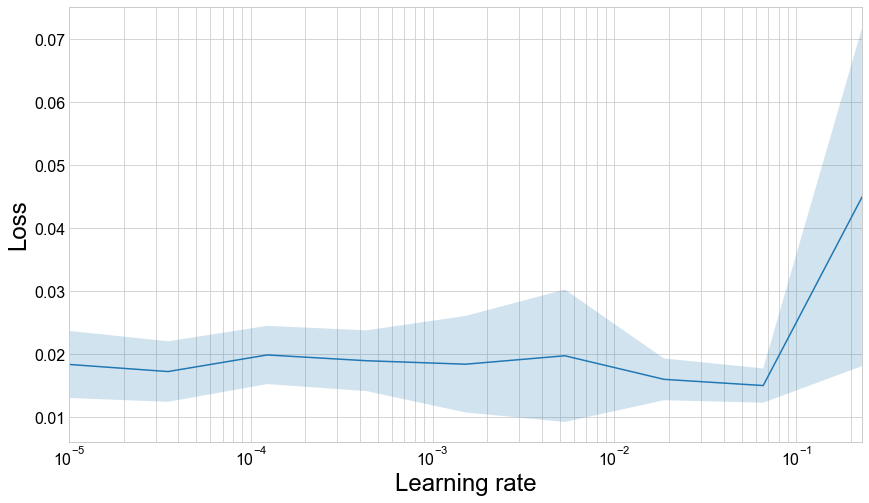

In [60]:
from lumin.optimisation.hyper_param import fold_lr_find
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e1], train_on_weights=True)

In [61]:
from lumin.nn.callbacks.cyclic_callbacks import CycleLR, OneCycle

n_models = 5
patience = 2
max_epochs = 50

#callback_args = [{'callback':OneCycle, 'kargs':{'lengths':[50, 150], 'lr_range':[3e-2, 3e-3], 'mom_range':[0.90, 0.99], 'interp':'cosine'}}]
callback_args = [{'callback':CycleLR, 'kargs':{'cycle_mult':2, 'lr_range':[1e-2, 0], 'interp':'cosine', 'scale':1}}]

plots = ['history']

`fold_train_ensemble` performs training of (an ensemble of) models produced by the `ModelBuilder` using data provided by a `FoldYielder`. Model training  runs for upto `max_epochs` number of epochs, or until `patience` number of sub-epochs (or cycles) have elapsed with out an improvment of the validation loss. The model is then saved to `saveloc` to be loaded later. The function returns results of the training and model perfomance on validation fold. If an `AbsCyclicCallback` is used, then snapshots of the model weights are automatically saved after each cycle to allow for [Snapshot Ensembling](https://arxiv.org/abs/1704.00109) or [Fast Geometric Ensembling](https://arxiv.org/abs/1802.10026).

Training model 1 / 5


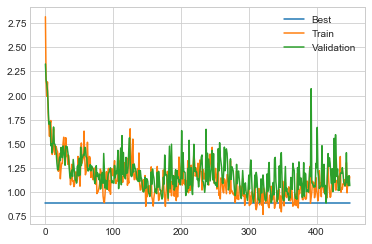

Scores are: {'loss': 0.88846755027771}
Fold took 107.056s

Training model 2 / 5


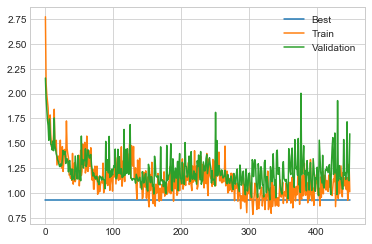

Scores are: {'loss': 0.928910493850708}
Fold took 107.994s

Training model 3 / 5


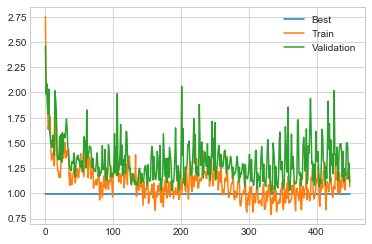

Scores are: {'loss': 0.9942670464515686}
Fold took 106.648s

Training model 4 / 5


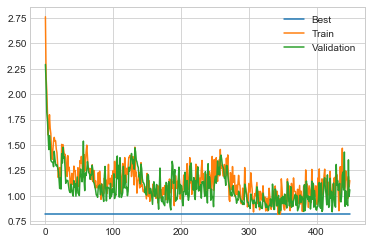

Scores are: {'loss': 0.8220995664596558}
Fold took 106.822s

Training model 5 / 5


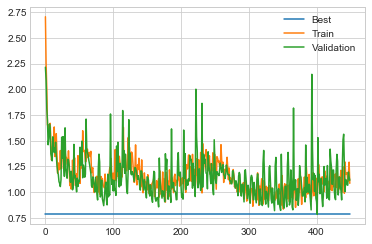

Scores are: {'loss': 0.7846044898033142}
Fold took 110.021s


______________________________________
Training finished
Cross-validation took 538.547s 


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

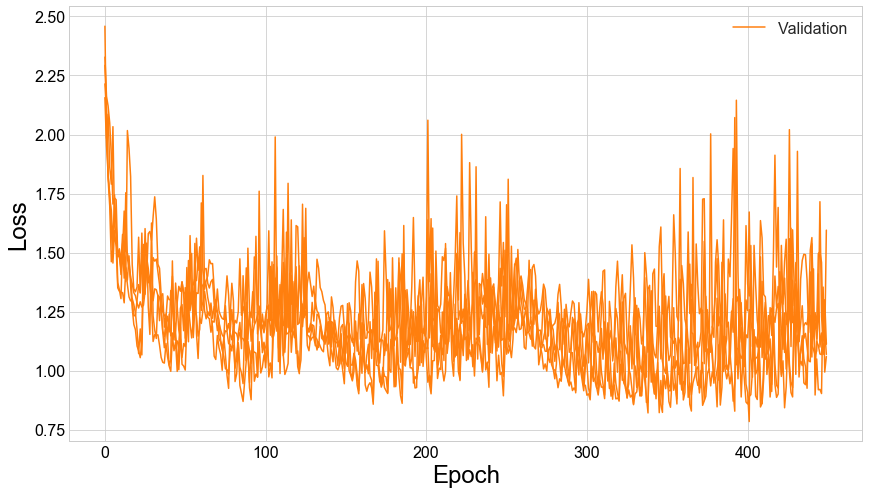

Mean loss = 0.88±0.03
______________________________________



<Figure size 432x288 with 0 Axes>

In [62]:
from lumin.nn.training.fold_train import fold_train_ensemble
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models, 
                                                       model_builder=model_builder,
                                                       bs=bs, train_on_weights=False,
                                                       callback_args=callback_args,
                                                       max_epochs=max_epochs, patience=patience,
                                                       plots=plots)

## Ensemble loading
We can now build an ensemble from the trained models, however rather than simply treating them all equally, we can weight them according to some metric (e.g. AMS, reciprocal of loss).

In [63]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [64]:
model_builder.emb_load_path = None

In [65]:
from lumin.nn.ensemble.ensemble import Ensemble
ensemble = Ensemble()
ensemble.build_ensemble(results, 5, model_builder, metric='loss')

Choosing ensemble by loss


Model 0 is 4 with loss = 0.7846044898033142
Model 1 is 3 with loss = 0.8220995664596558
Model 2 is 0 with loss = 0.88846755027771
Model 3 is 1 with loss = 0.928910493850708
Model 4 is 2 with loss = 0.9942670464515686


The default location is likely to be overwritten, so we can save it to a more permanent location.

In [66]:
name = 'weights/Multiclass_Classification_Unweighted'
ensemble.save(name, feats=train_feats, overwrite=True)

## Validation

In [67]:
from lumin.nn.ensemble.ensemble import Ensemble
ensemble = Ensemble()
ensemble.load('weights/Multiclass_Classification_Unweighted')

In [68]:
from lumin.nn.data.fold_yielder import FoldYielder
val_fy = FoldYielder(h5py.File(PATH/'val.hdf5', "r+"), cont_feats, cat_feats, ignore_feats=ignore_feats)

In [69]:
ensemble.predict(val_fy)

Mean time per event = 0.000147±7e-06


Remember we need to load the original class for the target, rather than the sample. We can then use `to_binary_class` to map the sample predictions to signal and background:
- sample = argmax pred_*
- pred = pred if sample == signal else 1-pred

In [70]:
val_df = val_fy.get_df(targ_name='targets')

894 candidates loaded


In [71]:
val_df.head()

,gen_target,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,...,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19,pred_20,pred_21
0,10.0,0.000013,0.292493,0.002775,0.000052,0.000027,0.000013,0.000371,0.000792,0.019023,...,0.000091,0.036548,0.000041,0.001506,0.000247,0.002931,0.000141,0.000023,0.000285,0.003374
1,14.0,0.000050,0.000991,0.001914,0.003474,0.000099,0.026721,0.000081,0.005150,0.000119,...,0.000036,0.000066,0.938973,0.000103,0.000083,0.000408,0.002648,0.000052,0.000392,0.000072
2,13.0,0.000003,0.069004,0.046204,0.000003,0.000190,0.000001,0.013209,0.003476,0.000872,...,0.000014,0.778503,0.000003,0.000971,0.000033,0.015708,0.000002,0.000015,0.000408,0.001790
3,13.0,0.000019,0.039732,0.192309,0.000013,0.007898,0.000004,0.156095,0.027325,0.000570,...,0.000048,0.517854,0.000006,0.006753,0.000308,0.007125,0.000006,0.000076,0.001101,0.003274
4,1.0,0.000009,0.258329,0.001974,0.000031,0.000015,0.000009,0.000256,0.000557,0.012837,...,0.000066,0.020640,0.000022,0.000993,0.000279,0.001640,0.000087,0.000018,0.000230,0.002633


In [72]:
val_df['pred'] = np.argmax(val_df[[f for f in val_df.columns if 'pred_' in f]].values, axis=1)

In [73]:
from sklearn.metrics import classification_report

In [74]:
print(classification_report(val_df.gen_target, val_df.pred))

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        11
         1.0       0.58      0.51      0.54        75
         2.0       0.77      0.89      0.83       101
         3.0       1.00      0.77      0.87        26
         4.0       0.00      0.00      0.00         5
         6.0       0.00      0.00      0.00        10
         7.0       0.81      0.96      0.88       245
         8.0       0.89      0.83      0.86        59
         9.0       0.00      0.00      0.00        16
        10.0       0.49      0.45      0.47        60
        11.0       0.92      0.40      0.56        30
        12.0       0.79      0.93      0.85        40
        13.0       0.62      0.82      0.71        67
        14.0       1.00      1.00      1.00         9
        15.0       0.70      0.92      0.80        64
        16.0       0.00      0.00      0.00         7
        17.0       0.47      0.36      0.41        45
        18.0       1.00    

In [43]:
print(classification_report(val_df.gen_target, val_df.pred))

              precision    recall  f1-score   support

         0.0       0.73      0.95      0.82       223
         1.0       0.65      0.90      0.75       103
         2.0       0.62      0.71      0.66        55
         3.0       0.91      1.00      0.95        21
         4.0       0.00      0.00      0.00        14
         5.0       0.92      0.61      0.73        18
         6.0       0.00      0.00      0.00         4
         7.0       0.00      0.00      0.00         1
         8.0       0.00      0.00      0.00        13
         9.0       0.50      0.11      0.18        56
        10.0       0.51      0.49      0.50        73
        11.0       0.96      0.78      0.86        69
        12.0       0.57      0.89      0.70         9
        13.0       0.94      0.50      0.65        34
        14.0       0.00      0.00      0.00         4
        15.0       0.50      0.25      0.33         4
        16.0       0.00      0.00      0.00         6
        17.0       0.00    

In [76]:
test_fy = FoldYielder(h5py.File(PATH/'test.hdf5', "r+"), cont_feats, cat_feats, ignore_feats=ignore_feats)
ensemble.predict(test_fy)
test_df = test_fy.get_df(targ_name='targets')
test_df['pred'] = np.argmax(test_df[[f for f in test_df.columns if 'pred_' in f]].values, axis=1)
print(classification_report(test_df.gen_target, test_df.pred))

Mean time per event = 7.1e-05±4e-06
2201 candidates loaded
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95        31
         1.0       0.52      0.40      0.45       185
         2.0       0.73      0.89      0.80       224
         3.0       0.97      0.78      0.86        45
         4.0       0.00      0.00      0.00        12
         5.0       0.00      0.00      0.00         1
         6.0       0.50      0.03      0.05        38
         7.0       0.75      0.95      0.84       564
         8.0       0.88      0.81      0.84       151
         9.0       0.50      0.04      0.07        55
        10.0       0.55      0.57      0.56       149
        11.0       0.92      0.37      0.53        91
        12.0       0.70      0.97      0.82        78
        13.0       0.53      0.71      0.61       146
        14.0       0.98      1.00      0.99        50
        15.0       0.63      0.89      0.74       142
        16.0       0.0

## Interpretation 
It could be interesting to see what the multiclass approach learns differently to the binary classification method.

In [77]:
from lumin.nn.ensemble.ensemble import Ensemble
ensemble = Ensemble()
ensemble.load('weights/Multiclass_Classification_Unweighted')

In [78]:
from lumin.nn.data.fold_yielder import HEPAugFoldYielder
train_fy = HEPAugFoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats, ignore_feats=ignore_feats)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


### Feature importance
In the same way as we used permutation importance to rank features with random forests, we can use the same technique to rank features with our ensemble.

Top ten most important features:
      Feature  Importance  Uncertainty
0   duration    2.019951     0.305407
1   peakFreq    1.988350     0.264290
2    GPStime    1.158468     0.172080
3        ifo    0.838281     0.135199
4        snr    0.728761     0.156739
5  bandwidth    0.316798     0.082144


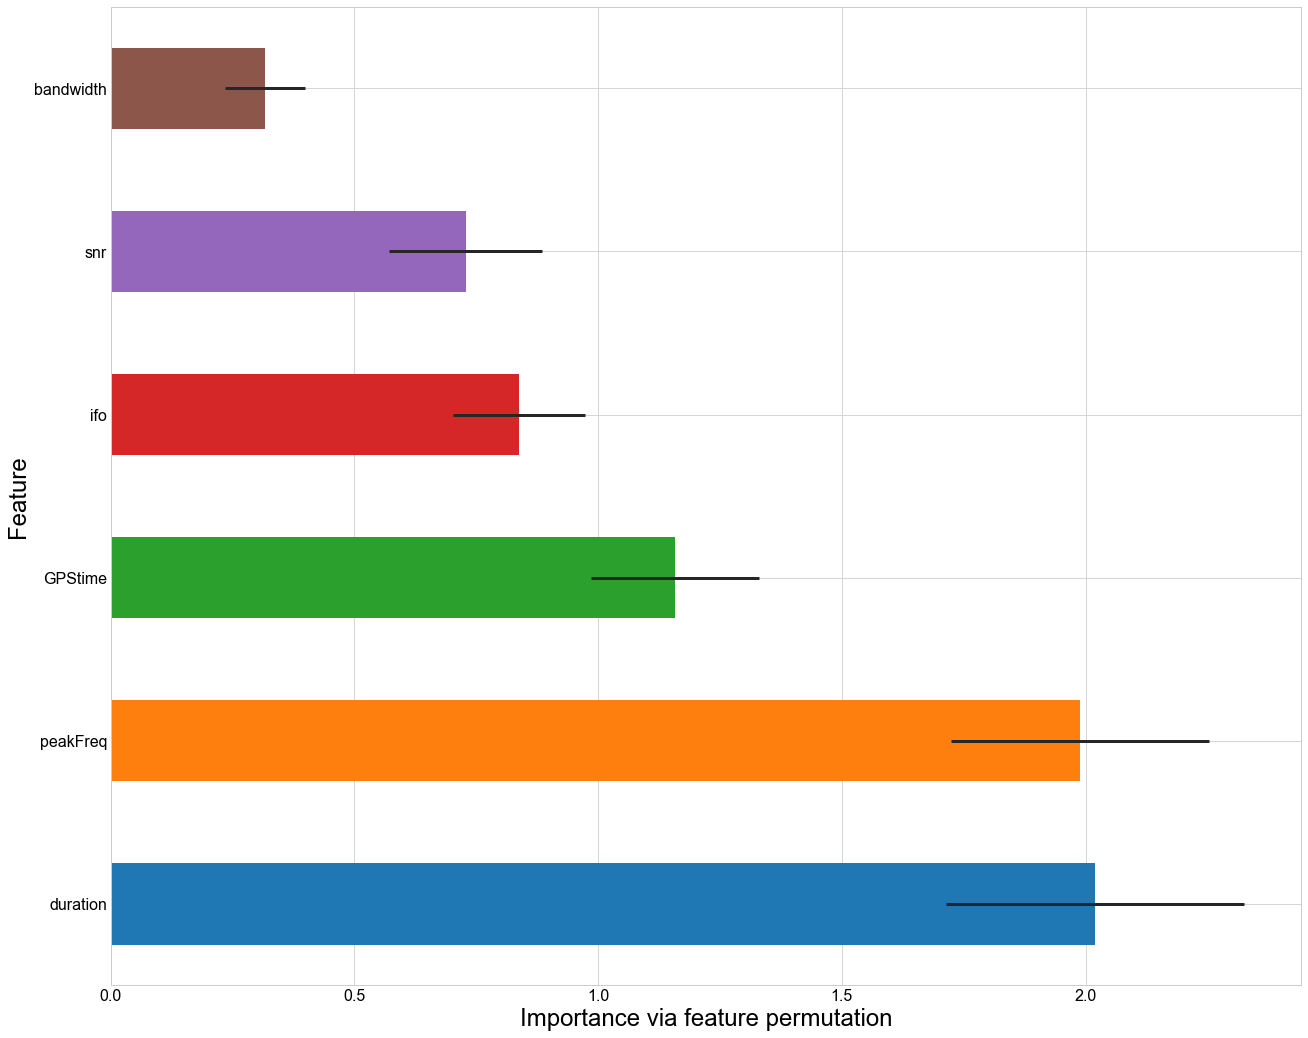

In [79]:
_ = ensemble.get_feat_importance(train_fy)

### Embeddings

In [80]:
_, m = ensemble[0]

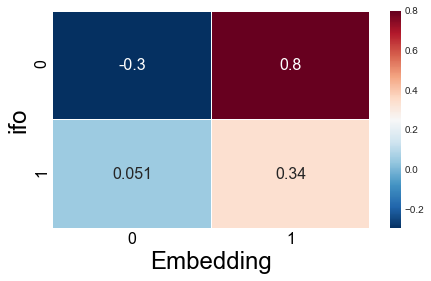

In [81]:
m.head.plot_embeds()